## 基本系統設置(本地執行)

In [ ]:
# # 更改繁體中文語系
!chcp 65001
# !chcp 437

Active code page: 65001


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
# 安裝必須設置
import sys
import subprocess
import pkg_resources

required = {'kaggle', 'tensorflow'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

C:\Users\112033645\AppData\Local\Temp\ipykernel_19192\2115042831.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## 資料集準備

### 使用學姊資料

In [ ]:
# api token download data
import json
import os
import subprocess

# Define the API token for Kaggle authentication
api_token = {"username": "pinhsuanlee", "key": "28c330210349e9af127aaf6f88dfa39f"}

# Specify the directory where the Kaggle data will be stored
data_dir = "kaggle_data"

# Construct the path for the Kaggle API credentials file
api_js_file = os.path.join(data_dir, "kaggle.json")  # Removed the leading slash from the file name

# Create the data directory if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Write the API token to the credentials file
with open(api_js_file, 'w') as file:
    json.dump(api_token, file)

# Set the file permissions to read and write for the owner (600 in octal)
os.chmod(api_js_file, 0o600)

# Set the environment variable for the Kaggle configuration directory
os.environ['KAGGLE_CONFIG_DIR'] = data_dir

# Download the specified Kaggle dataset using the Kaggle API
subprocess.run(["kaggle", "datasets", "download", "-d", "pinhsuanlee/t-max-sxv1", "--force"])  # Corrected 'runn' to 'run'

# List the contents of the data directory and print them
print(os.listdir(data_dir))


['kaggle.json']


In [ ]:
# 解壓縮資料集
import zipfile

zip_data = 't-max-sxv1.zip'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if os.path.exists(zip_data):
    with zipfile.ZipFile(zip_data, 'r') as zip_ref: # 解壓縮
        zip_ref.extractall(data_dir)

### 使用學長資料

#### 本地端

In [ ]:
!cd

f:\Code\Embryo-Hyperspectral-DL-Recognition-System


In [ ]:
data_dir = os.getcwd()

#### 雲端

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/Code/Embryo-Hyperspectral-DL-Recognition-System/"

## 準備資料

In [ ]:
import os
# 設置基本資料夾
all_data_path = os.path.join(data_dir, 'dataset')

test_dir = os.path.join(all_data_path, 'test_set')
test_good_dir = os.path.join(test_dir, 'good')
test_bad_dir = os.path.join(test_dir, 'bad')
train_dir = os.path.join(all_data_path, 'training_set')
train_good_dir = os.path.join(train_dir, 'good')
train_bad_dir = os.path.join(train_dir, 'bad')

In [ ]:
# 基本資料數量
def img_num_in_dir(dir_path):
    return len(os.listdir(dir_path))

print(
    f"""
    There are:
        {img_num_in_dir(train_good_dir)} good picture for training,
        {img_num_in_dir(train_bad_dir)} bad picture for training,
        {img_num_in_dir(test_good_dir)} good picture for testing,
        {img_num_in_dir(test_bad_dir)} bad picture for testing.
    """
)


    There are:
        68 good picture for training,
        74 bad picture for training,
        8 good picture for testing,
        9 bad picture for testing.
    


In [ ]:
32/42, 8/10

(0.7619047619047619, 0.8)

## 資料夾圖像擴增
為了能讓訓練資料及平衡


In [ ]:
import os
import tensorflow as tf
import datetime
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img

def augment_image(image_path, augmentation_fn):
    """對單個圖像進行擴增並儲存擴增後的圖像。

    參數:
        image_path (str): 原始圖像的路徑。
        save_dir (str): 儲存擴增圖像的目錄。
        augmentation_fn (callable): 用於擴增圖像的函數
    """
    image = load_img(image_path, color_mode="grayscale")
    image = img_to_array(image)
    image = tf.expand_dims(image, 0)

    augument_image = augmentation_fn(image)
    return tf.squeeze(augument_image, 0)

def save_image_to_dir(image_path, image, save_dir):
    # 在文件名中添加一个随机数以避免重复
    minute = datetime.datetime.now().minute
    save_path = os.path.join(save_dir, f"aug_{minute}_{os.path.basename(image_path)}")
    save_img(save_path, image.numpy())

data_augmetation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

target_dir = train_good_dir
compare_dir = train_bad_dir
names = os.listdir(target_dir)

# 持续增强和保存图像直到两个目录的图像数量相等
while len(os.listdir(target_dir)) < len(os.listdir(compare_dir)):
    for image_name in names:
        image_path = os.path.join(target_dir, image_name)
        img = augment_image(image_path, data_augmetation)
        save_image_to_dir(image_path, img, target_dir)
        if len(os.listdir(target_dir)) >= len(os.listdir(compare_dir)):
            break

print(
    f"""
    There are:
        {img_num_in_dir(train_good_dir)} good picture for training,
        {img_num_in_dir(train_bad_dir)} bad picture for training,
        {img_num_in_dir(test_good_dir)} good picture for testing,
        {img_num_in_dir(test_bad_dir)} bad picture for testing.
    """
)


    There are:
        74 good picture for training,
        74 bad picture for training,
        8 good picture for testing,
        9 bad picture for testing.
    


In [ ]:
# !rm -rf kaggle_data/

## 圖片基本性質

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
os.listdir(train_good_dir)

['20220117-3010092_T13.png',
 '20220117-6684773_T13.png',
 '20220118-6761200_T13.png',
 '20220301-6835211_T13.png',
 '20220302-4543915_T13.png',
 '20220302-6835249_T13.png',
 '20220310-6202254_T13.png',
 '20220323-6939097_T13.png',
 '20220324-6542948_T13.png',
 '20220326-5050699_T13.png',
 '20220326-6987138_T13.png',
 '20220406-5382322_T13.png',
 '20220406-6829909_T13.png',
 '20220406-6903457_T13.png',
 '20220411-6128886_T13.png',
 '20220426-6532388_T13.png',
 '20220426-6693882_T13.png',
 '20220506-6982244_T13.png',
 '20220511-6814593_T13.png',
 '20220513-6771420_T13.png',
 '20220518-3242786_T13.png',
 '20220523-4545498_T13.png',
 '20220524-6629771_T13.png',
 '20220531-5938194_T13.png',
 '20220531-6537207_T13.png',
 '20220531-6806575_T13.png',
 '20220606-6056580_T13.png',
 '20220618-6682123_T13.png',
 '20220622-5542328_T13.png',
 '20220629-6743696_T13.png',
 '20220704-6808952_T13.png',
 '20220705-7026191_T13.png',
 '20220711-6516435_T13.png',
 '20220712-7023081_T13.png',
 '20220718-702

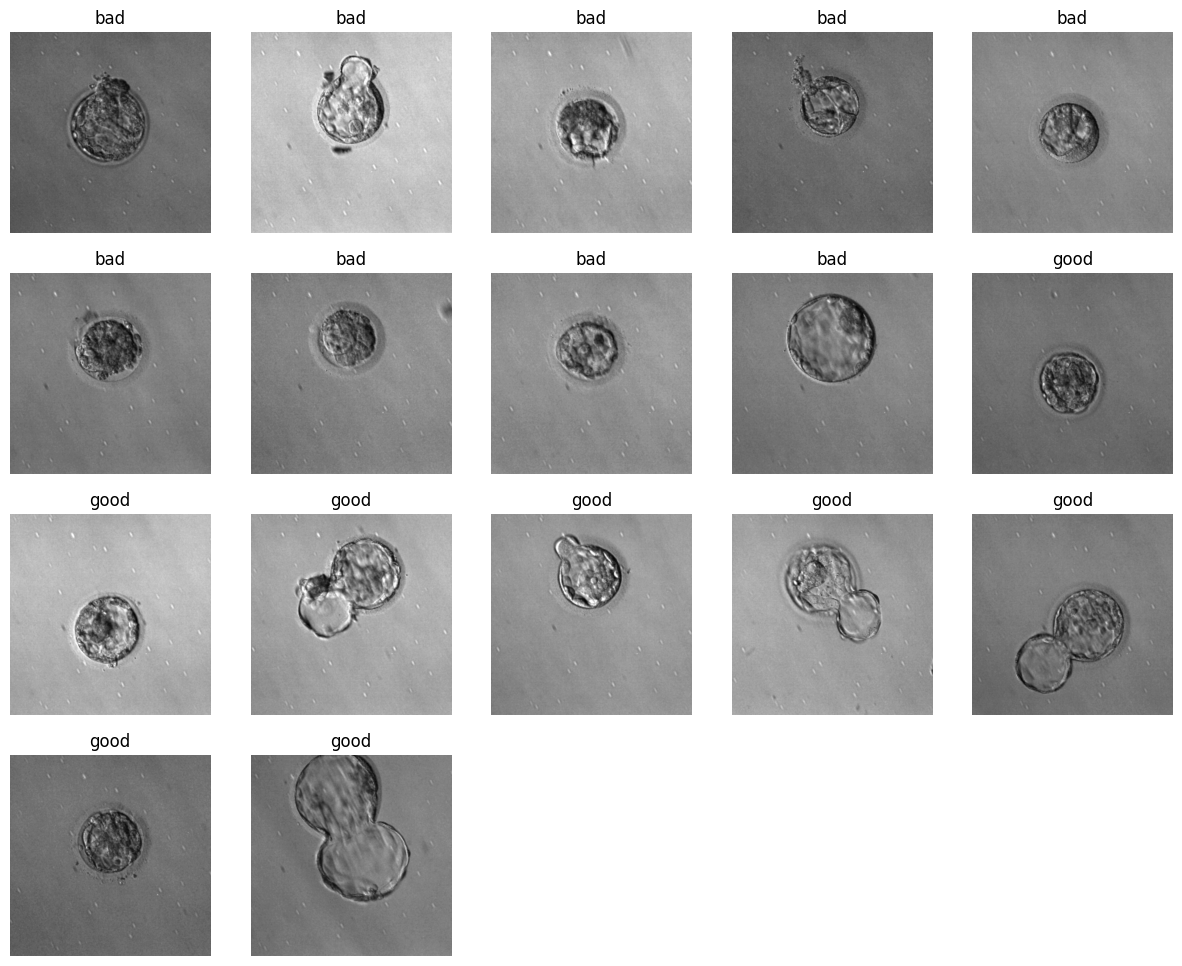

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# target_dir = train_good_dir
# target_images = os.listdir(target_dir)

target_images_bad = [(os.path.join(test_bad_dir, img), 'bad') for img in os.listdir(test_bad_dir)]
target_images_good = [(os.path.join(test_good_dir, img), 'good') for img in os.listdir(test_good_dir)]
target_images = target_images_bad + target_images_good

clomn_number = 5
row_number = int(np.ceil(len(target_images) / clomn_number))
fig_size = (clomn_number*3, row_number*3)

fig, axs = plt.subplots(row_number, clomn_number, figsize=fig_size)

# 確保axs始終是二維的
if row_number == 1:
    axs = axs[np.newaxis, :]  # 將axs轉換為二維陣列

for i, (image_path, label) in enumerate(target_images):
    img = np.asarray(Image.open(image_path))

    ax = axs[i // clomn_number, i % clomn_number]
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

# 將多出來的子圖設置為空
for i in range(len(target_images), row_number * clomn_number):
    ax = axs[i // clomn_number, i % clomn_number]
    ax.axis('off')

plt.show()

In [ ]:
# 了解隨機圖像的資訊
import random
sample_dir = train_bad_dir
sample_name = random.choice(os.listdir(sample_dir))
sample_path = os.path.join(sample_dir, sample_name)

sample_image = Image.open(image_path)
print(f'''
      Name of sample image:   {sample_name}
      Format of sample image: {sample_image.format}
      Size of sample image:   {sample_image.size}
      Mode of sample image:   {sample_image.mode}''')
sample_image.show()


      Name of sample image:   20220629-7028452_T13.png
      Format of sample image: PNG
      Size of sample image:   (1000, 1000)
      Mode of sample image:   L


In [ ]:
# print出sample array的值
np.set_printoptions(threshold=np.inf)
sample_array = np.array(sample_image)
# print(sample_array)

In [ ]:
# print 出圖片的最大最小值
print([(a.max(), a.min()) for a in sample_array])
print(np.array([a.max() for a in sample_array]).max())
print(np.array([a.min() for a in sample_array]).min())

[(157, 118), (158, 118), (158, 118), (160, 117), (160, 119), (157, 119), (157, 119), (156, 117), (156, 116), (157, 114), (157, 112), (157, 113), (157, 114), (157, 117), (158, 119), (158, 115), (157, 112), (157, 113), (157, 114), (157, 116), (160, 115), (165, 115), (168, 116), (166, 116), (164, 116), (161, 116), (160, 115), (160, 117), (161, 117), (162, 117), (164, 117), (159, 117), (160, 116), (157, 115), (157, 116), (157, 118), (157, 116), (157, 117), (157, 116), (157, 114), (157, 115), (158, 115), (158, 114), (162, 113), (158, 114), (158, 113), (158, 112), (158, 111), (157, 112), (160, 112), (164, 114), (168, 115), (171, 118), (173, 117), (175, 114), (175, 114), (176, 115), (179, 116), (182, 114), (182, 112), (180, 114), (179, 115), (178, 116), (177, 115), (176, 114), (175, 115), (175, 116), (172, 117), (167, 116), (160, 117), (161, 117), (164, 115), (163, 116), (161, 116), (160, 115), (161, 113), (164, 112), (167, 111), (169, 111), (163, 112), (162, 114), (160, 116), (164, 116), (16

## 創建訓練資料集

In [ ]:
import tensorflow as tf

# 設定資料集參數
batch_size = 1
img_height = 700
img_width = 700

# 從目錄創建訓練資料集
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,  # 訓練資料集的目錄
    labels='inferred',          # 從子資料夾名稱推斷標籤
    label_mode='binary',        # 二元分類
    color_mode='grayscale',     # 灰階圖像
    batch_size=batch_size,
    image_size=(img_height, img_width),  # 調整圖像大小
    shuffle=True,               # 打亂資料
)
# 從目錄創建訓練資料集
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,  # 訓練資料集的目錄
    labels='inferred',          # 從子資料夾名稱推斷標籤
    label_mode='binary',        # 二元分類
    color_mode='grayscale',     # 灰階圖像
    batch_size=batch_size,
    image_size=(img_height, img_width),  # 調整圖像大小
)

# 設定預處理層
normalization_layer = tf.keras.layers.Rescaling(1./255)  # 將像素值歸一化到 [0,1]
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# 設定資料集性能參數
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 148 files belonging to 2 classes.
Found 17 files belonging to 2 classes.


In [ ]:
y_labels = []
for images, labels in test_ds:
    y_labels.append(labels.numpy().astype(int))
y_labels = tf.squeeze(y_labels)
class_names = sorted(os.listdir(train_dir))

In [ ]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

!curl https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py -o helper_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10246  100 10246    0     0  19453      0 --:--:-- --:--:-- --:--:-- 19479


## 建立模型

### 學姊的模型

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

def senior_sister_net():
    '''學姊的神經網路架構，除了最終輸出是2class之外
    '''
    inputs = tf.keras.layers.Input(shape=(700, 700, 1))
    x = layers.Conv2D(filters=20, kernel_size=13, strides=4, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(filters=30, kernel_size=13, strides=4, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=1000, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs=inputs, outputs=outputs)

# Create an instance of the model
net = senior_sister_net()

# Compile the model
net.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
            loss=losses.BinaryCrossentropy(),
            metrics=['accuracy'])

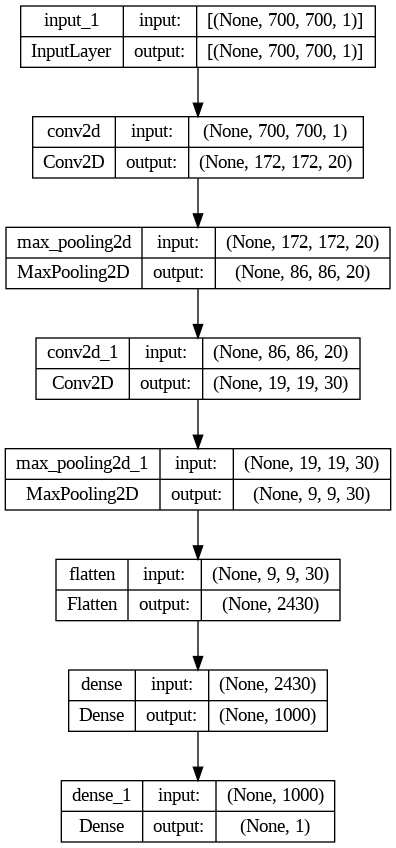

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(net, show_shapes=True, show_layer_names=True)

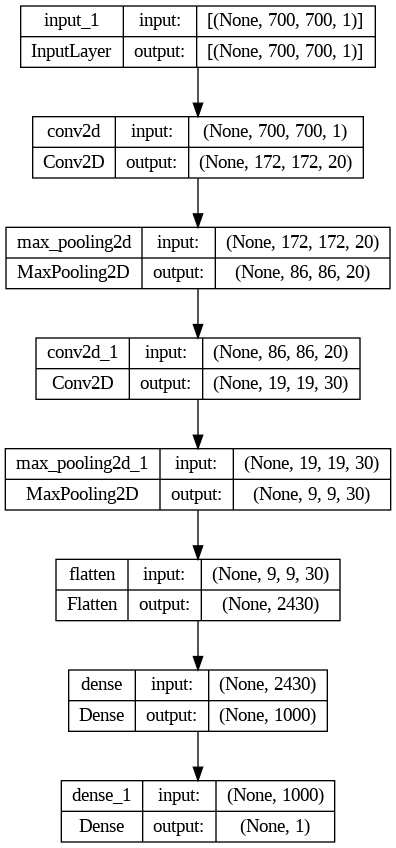

In [ ]:
plot_model(net, show_shapes=True, show_layer_names=True, to_file='model.png')

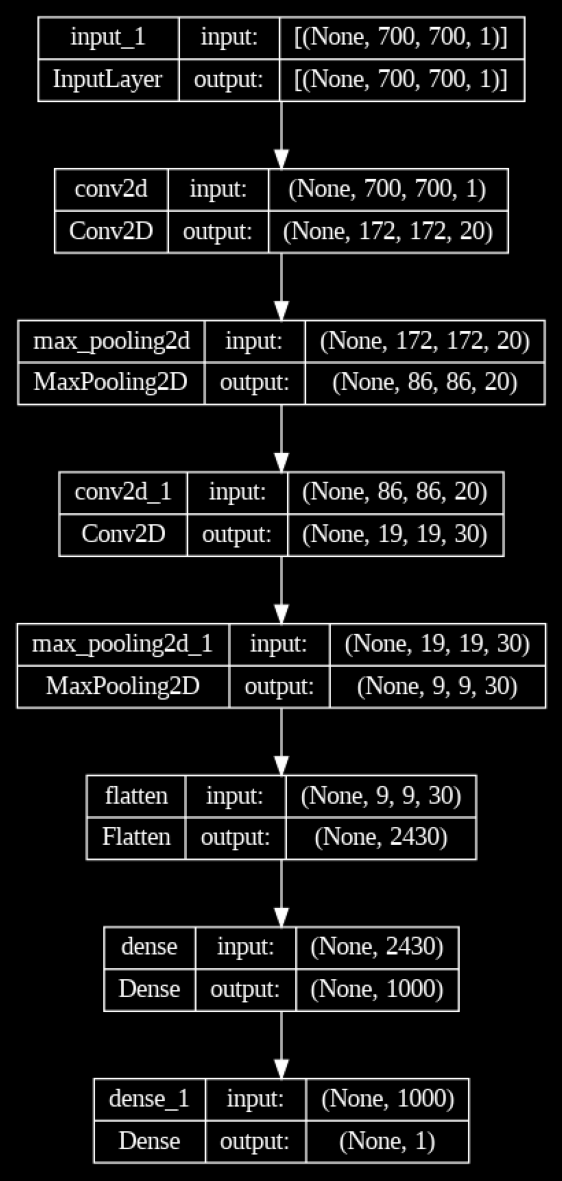

In [ ]:
import cv2

# 讀取圖片
img = cv2.imread('model.png', cv2.IMREAD_GRAYSCALE)

# 反轉像素值
negative_img = cv2.bitwise_not(img)

# 顯示負片效果的圖片
plt.figure(figsize=(img.shape[1]//50, img.shape[0]//50), facecolor='black')
plt.imshow(negative_img, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
input_shape = (700, 700, 1)
net.build(input_shape)

# Train the model
history = net.fit(
      train_ds,
      epochs=30,
      validation_data=test_ds)

Epoch 1/30
148/148 [==============================] - 37s 209ms/step - loss: 0.6930 - accuracy: 0.5743 - val_loss: 0.6956 - val_accuracy: 0.4706
Epoch 2/30
148/148 [==============================] - 1s 5ms/step - loss: 0.6984 - accuracy: 0.4932 - val_loss: 0.6953 - val_accuracy: 0.4706
Epoch 3/30
148/148 [==============================] - 1s 5ms/step - loss: 0.6975 - accuracy: 0.4797 - val_loss: 0.6955 - val_accuracy: 0.4706
Epoch 4/30
148/148 [==============================] - 1s 4ms/step - loss: 0.6970 - accuracy: 0.4662 - val_loss: 0.6961 - val_accuracy: 0.4706
Epoch 5/30
148/148 [==============================] - 1s 4ms/step - loss: 0.6973 - accuracy: 0.4527 - val_loss: 0.6957 - val_accuracy: 0.4706
Epoch 6/30
148/148 [==============================] - 1s 5ms/step - loss: 0.6969 - accuracy: 0.4595 - val_loss: 0.6958 - val_accuracy: 0.4706
Epoch 7/30
148/148 [==============================] - 1s 6ms/step - loss: 0.6970 - accuracy: 0.4595 - val_loss: 0.6964 - val_accuracy: 0.4706
Epo

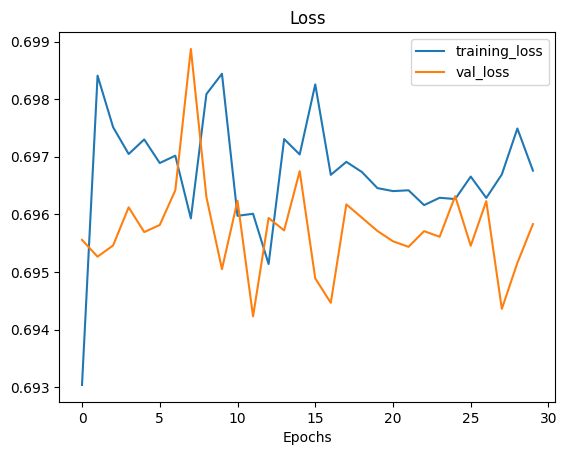

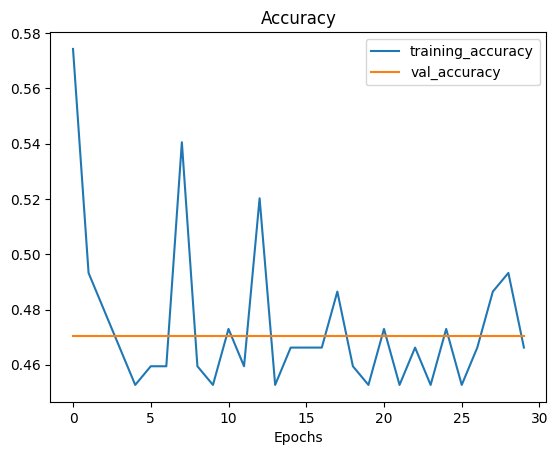

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(history)

In [ ]:
y_pred_probs = net.predict(test_ds)

17/17 [==============================] - 0s 3ms/step


In [ ]:
y_preds = (y_pred_probs > 0.5).astype(int)
y_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

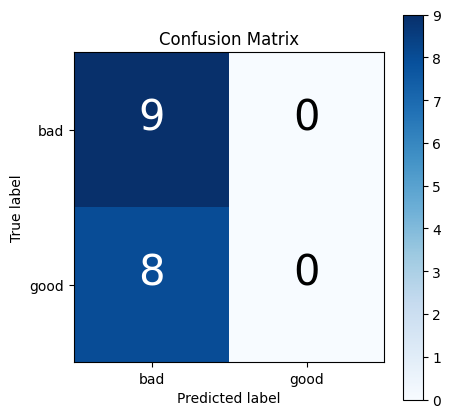

In [ ]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels, y_pred=y_preds, classes=class_names, figsize=(5, 5), text_size=30, norm=False, savefig=False)

### 嘗試模型

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

inputs = tf.keras.layers.Input(shape=(700, 700, 1))
x = layers.Conv2D(filters=10, kernel_size=3, strides=2, activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(filters=15, kernel_size=3, strides=2, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(filters=20, kernel_size=3, strides=2, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(units=100, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=optimizers.Adam(),
              loss=losses.BinaryCrossentropy(from_logits=False),

              metrics=['accuracy'])

# Train the model
history_2 = model.fit(
      train_ds,
      epochs=30,
      validation_data=test_ds)

Epoch 1/30
64/64 [==============================] - 4s 11ms/step - loss: 0.6959 - accuracy: 0.4062 - val_loss: 0.6909 - val_accuracy: 0.8000
Epoch 2/30
64/64 [==============================] - 1s 9ms/step - loss: 0.6947 - accuracy: 0.3906 - val_loss: 0.6932 - val_accuracy: 0.3000
Epoch 3/30
64/64 [==============================] - 1s 9ms/step - loss: 0.6944 - accuracy: 0.3750 - val_loss: 0.6934 - val_accuracy: 0.2000
Epoch 4/30
64/64 [==============================] - 1s 8ms/step - loss: 0.6953 - accuracy: 0.4375 - val_loss: 0.6932 - val_accuracy: 0.7000
Epoch 5/30
64/64 [==============================] - 1s 9ms/step - loss: 0.6952 - accuracy: 0.4375 - val_loss: 0.6945 - val_accuracy: 0.2000
Epoch 6/30
64/64 [==============================] - 1s 9ms/step - loss: 0.6954 - accuracy: 0.4062 - val_loss: 0.6910 - val_accuracy: 0.8000
Epoch 7/30
64/64 [==============================] - 1s 8ms/step - loss: 0.6942 - accuracy: 0.4531 - val_loss: 0.6941 - val_accuracy: 0.2000
Epoch 8/30
64/64 [=

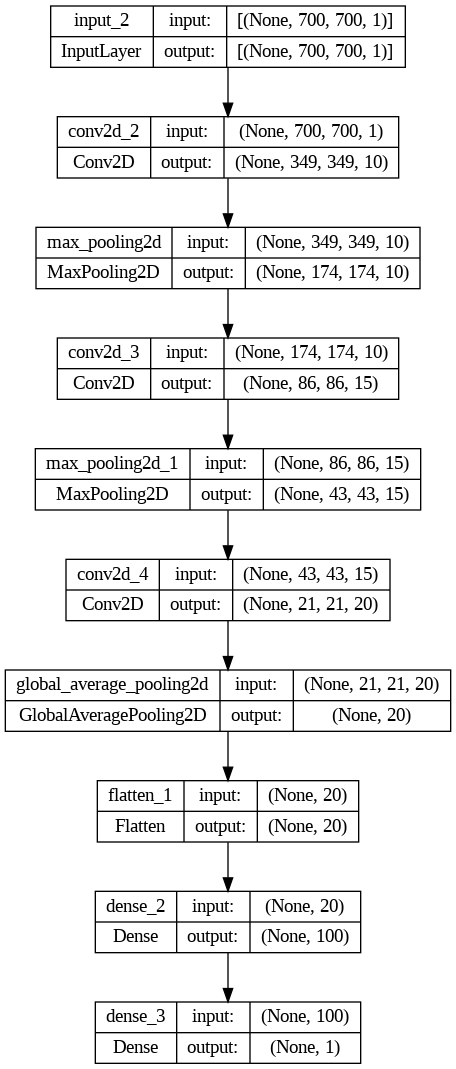

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

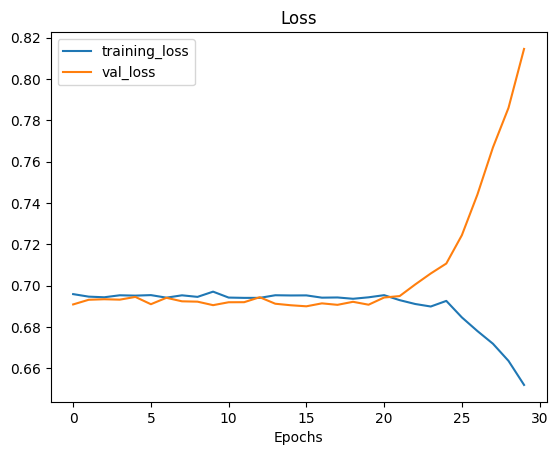

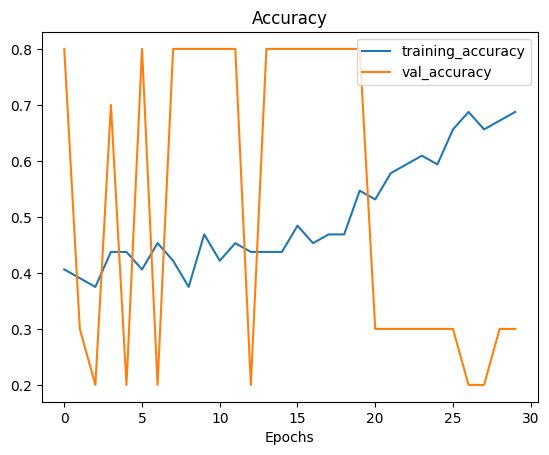

In [ ]:
plot_loss_curves(history_2)

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 700, 700, 1)]     0         
                                                                 
 conv2d_27 (Conv2D)          (None, 349, 349, 20)      200       
                                                                 
 max_pooling2d (MaxPooling2  (None, 174, 174, 20)      0         
 D)                                                              
                                                                 
 conv2d_28 (Conv2D)          (None, 86, 86, 20)        3620      
                                                                 
 global_average_pooling2d (  (None, 20)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten_8 (Flatten)         (None, 20)                0   

In [ ]:
# net.save('path_to_my_model')
# loaded_model = tf.keras.models.load_model('path_to_my_model')

## Visaulize CNN

### Attention *map*

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def preprocess(img_path, target_size):
    img = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale', target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    return np.expand_dims(img, 0)

def get_activations_at(input_img, model, layer_index):
    out_layer = model.layers[layer_index]
    intermediate_model = tf.keras.models.Model(inputs=model.inputs, outputs=out_layer.output)
    return intermediate_model.predict(input_img)

def postprocess_activations(activations, target_size):
    output = np.abs(activations)
    output = np.sum(output, axis=-1).squeeze()
    output = cv2.resize(output, target_size)
    output /= output.max()
    output *= 255
    return 255 - output.astype('uint8')

def apply_heatmap(weights, img):
    heatmap = cv2.applyColorMap(weights, cv2.COLORMAP_JET)
    heatmap = cv2.addWeighted(heatmap, 0.7, img, 0.3, 0)
    return heatmap

def get_intermediate_models(model, layer_indices):
    intermediate_models = []
    for i in layer_indices:
        out_layer = model.layers[i]
        intermediate_model = tf.keras.models.Model(inputs=model.inputs, outputs=out_layer.output)
        intermediate_models.append(intermediate_model)
    return intermediate_models

def plot_heatmap(img_path, target_size, model, layer_indices):
    input_img = preprocess(img_path, target_size=target_size)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    intermediate_models = get_intermediate_models(model, layer_indices)

    level_maps = None
    for intermediate_model in intermediate_models:
        activations = intermediate_model.predict(input_img)
        weights = postprocess_activations(activations, target_size)
        heatmap = apply_heatmap(weights, img)
        if level_maps is None:
            level_maps = heatmap
        else:
            level_maps = np.concatenate([level_maps, heatmap], axis=1)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(level_maps)
    plt.show()


In [ ]:
import random
sample_dir = train_good_dir
sample_name = random.choice(os.listdir(sample_dir))
sample_path = os.path.join(sample_dir, sample_name)
plt.imshow(plt.imread(sample_path), cmap="gray")
plot_heatmap(img_path=sample_path, target_size=(700, 700), model=net, layer_indices=range(1, 3))
pred = net.predict(preprocess(img_path=sample_path, target_size=(700, 700)))
print(sample_name, "\n", np.array(pred))

In [ ]:
def get_heatmap(img_path, target_size, model, layer_indices):
    input_img = preprocess(img_path, target_size=target_size)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    intermediate_models = get_intermediate_models(model, layer_indices)

    level_maps = None
    for intermediate_model in intermediate_models:
        activations = intermediate_model.predict(input_img)
        weights = postprocess_activations(activations, target_size)
        heatmap = apply_heatmap(weights, img)
        if level_maps is None:
            level_maps = heatmap
        else:
            level_maps = np.concatenate([level_maps, heatmap], axis=1)

    return level_maps

In [ ]:
net.layers[1].name

'conv2d'

1/1 [==============================] - 0s 18ms/step


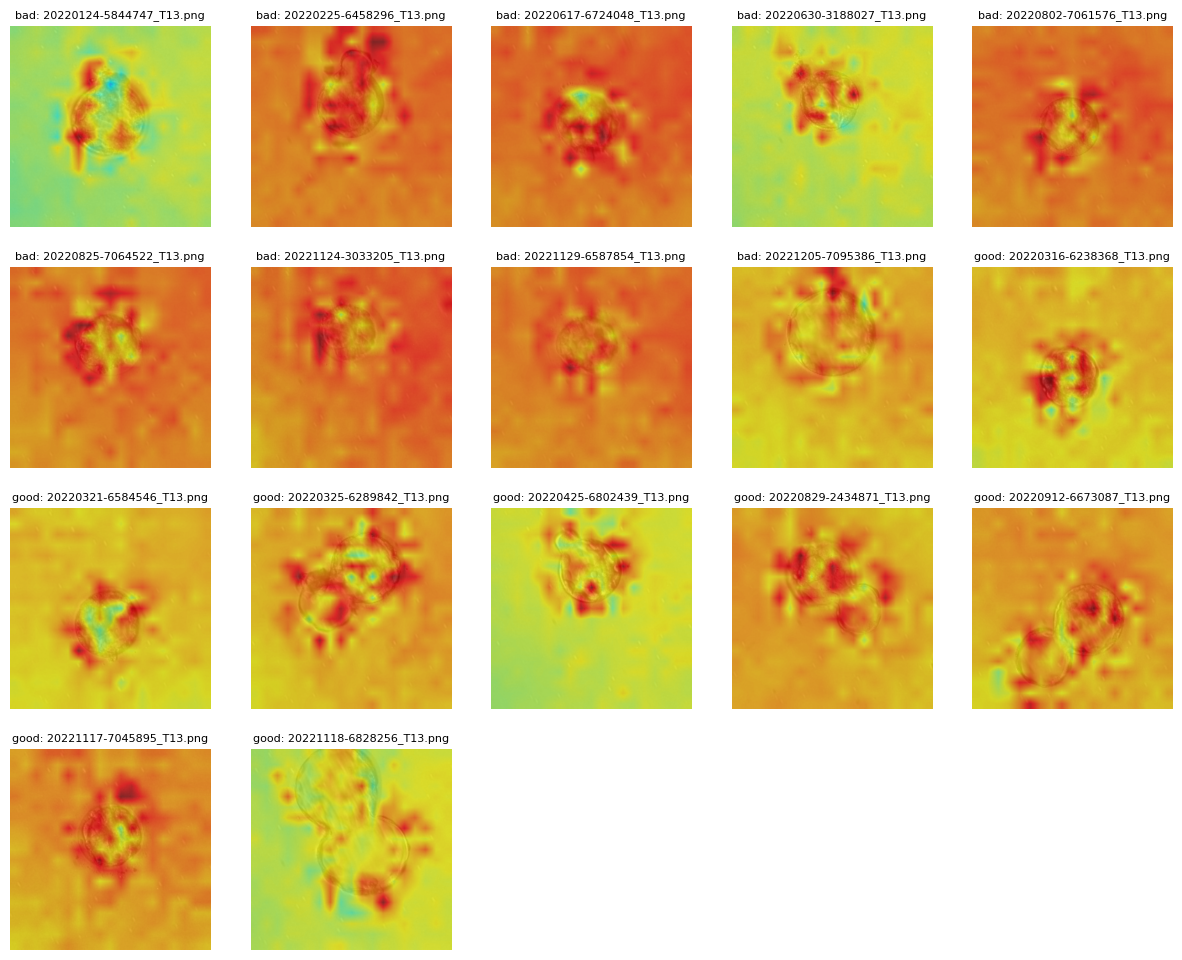

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os


target_model = net

# Combine images from both directories
target_images_bad = [(os.path.join(test_bad_dir, img), 'bad') for img in os.listdir(test_bad_dir)]
target_images_good = [(os.path.join(test_good_dir, img), 'good') for img in os.listdir(test_good_dir)]
target_images = target_images_bad + target_images_good

# Determine the number of rows and columns for the subplot
column_number = 5
row_number = int(np.ceil(len(target_images) / column_number))
fig_size = (column_number * 3, row_number * 3)

# Create subplots
fig, axs = plt.subplots(row_number, column_number, figsize=fig_size)

# Ensure 'axs' is always 2D
if row_number == 1:
    axs = axs[np.newaxis, :]  # Convert 'axs' to a 2D array

# Display each image and its heatmap
for i, (image_path, label) in enumerate(target_images):
    img = np.asarray(Image.open(image_path))
    ax = axs[i // column_number, i % column_number]
    ax.imshow(get_heatmap(img_path=image_path, target_size=(700, 700), model=target_model, layer_indices=[3]))
    pred = target_model.predict(preprocess(img_path=image_path, target_size=(700, 700)))
    ax.set_title(f"{label}: {os.path.basename(image_path)}", fontsize=8)
    ax.axis('off')

# Set any remaining subplots to empty
for i in range(len(target_images), row_number * column_number):
    ax = axs[i // column_number, i % column_number]
    ax.axis('off')

plt.show()


In [ ]:
net.layers[3]

### Visualize CNN filter

In [ ]:
import matplotlib.image as mpimg
import math

In [ ]:
def make_random_image(img_height=700, img_width=700, shift=True):
  img = tf.random.uniform((1, img_width, img_height, 1))
  if shift:
    return (img -0.5) * 0.25
  return img * 0.25

In [ ]:
def convert_to_image(x: np.array):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.15

  x += 0.5
  x = np.clip(x, 0, 1)

  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
@tf.function
def gradient_ascent_filter(img, filter_index, step_size, model):
  with tf.GradientTape() as tape:
    tape.watch(img)

    activation = model(img)

    filter_activation = activation[:, 2:-2, 2:-2, filter_index]

    loss = tf.reduce_mean(filter_activation)

  grads = tape.gradient(loss, img)

  grads = tf.math.l2_normalize(grads)

  img += step_size * grads

  return img

In [ ]:
def visualize_filter(model, input_img, layer_name, filter_index, steps=50, step_size=10.0):
  img = input_img

  layer = model.get_layer(layer_name)

  feature_extractor = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

  for iteration in range(steps):
    img = gradient_ascent_filter(img, filter_index, step_size, feature_extractor)

  img = convert_to_image(tf.squeeze(img).numpy())

  return img


In [ ]:
import random
from tqdm import tqdm

def visualize_filters(model, layer_name, max_filters=20, steps=80, step_size=10.0, shift=True):

  input_img = make_random_image(shift=shift)
  num_filter = model.get_layer(layer_name).output.shape[3]
  if max_filters >  num_filter:
    max_filters = num_filter

  print(f'Showing {max_filters} random filters in {layer_name}')

  plt.figure(figsize=(16, 16), facecolor='black')
  plt.title(layer_name, color="white")

  col_num = int(math.sqrt(max_filters))
  row_num = max_filters  // col_num
  if max_filters %col_num != 0:
    row_num += 1

  idxs = random.sample(range(num_filter), max_filters)
  for i, idx in enumerate(tqdm(idxs)):
    result = visualize_filter(model, input_img, layer_name, filter_index=idx, steps=steps, step_size=step_size)
    plt.subplot(col_num, row_num, i+1)
    plt.imshow(result, cmap='gray')
    plt.gca().set_title(f"L:{idx}", color='white')
    plt.axis('off')


  plt.tight_layout()
  plt.show()


In [ ]:
layer_name = net.layers[3].name
visualize_filters(model=net,
                  layer_name=layer_name,
                  max_filters=15,
                  steps=50,
                  step_size=10.0,
                  shift=True)

Output hidden; open in https://colab.research.google.com to view.

### Visualize layer output

In [ ]:
target_model = net

In [ ]:
for layer in target_model.layers:
    if 'conv' not in layer.name:
        continue
    filters, bias = layer.get_weights()
    print(layer.name, filters.shape)

conv2d (13, 13, 1, 20)
conv2d_1 (13, 13, 20, 30)


In [ ]:
target_layer_num = 3

In [ ]:
target_model = tf.keras.Model(inputs=target_model.inputs, outputs=target_model.layers[target_layer_num].output)

In [ ]:
import random
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

sample_dir = test_bad_dir
sample_name = random.choice(os.listdir(sample_dir))
sample_path = os.path.join(sample_dir, sample_name)

sample_img = load_img(sample_path, target_size=(700, 700), color_mode='grayscale')
sample_img = img_to_array(sample_img)
sample_img /= 255.0  # 影像歸一化處理

sample_img = np.expand_dims(sample_img, axis=0)

In [ ]:
sample_img.shape

(1, 700, 700, 1)

In [ ]:
features = target_model.predict(sample_img)
print(features.shape)

1/1 [==============================] - 0s 25ms/step
(1, 172, 172, 20)


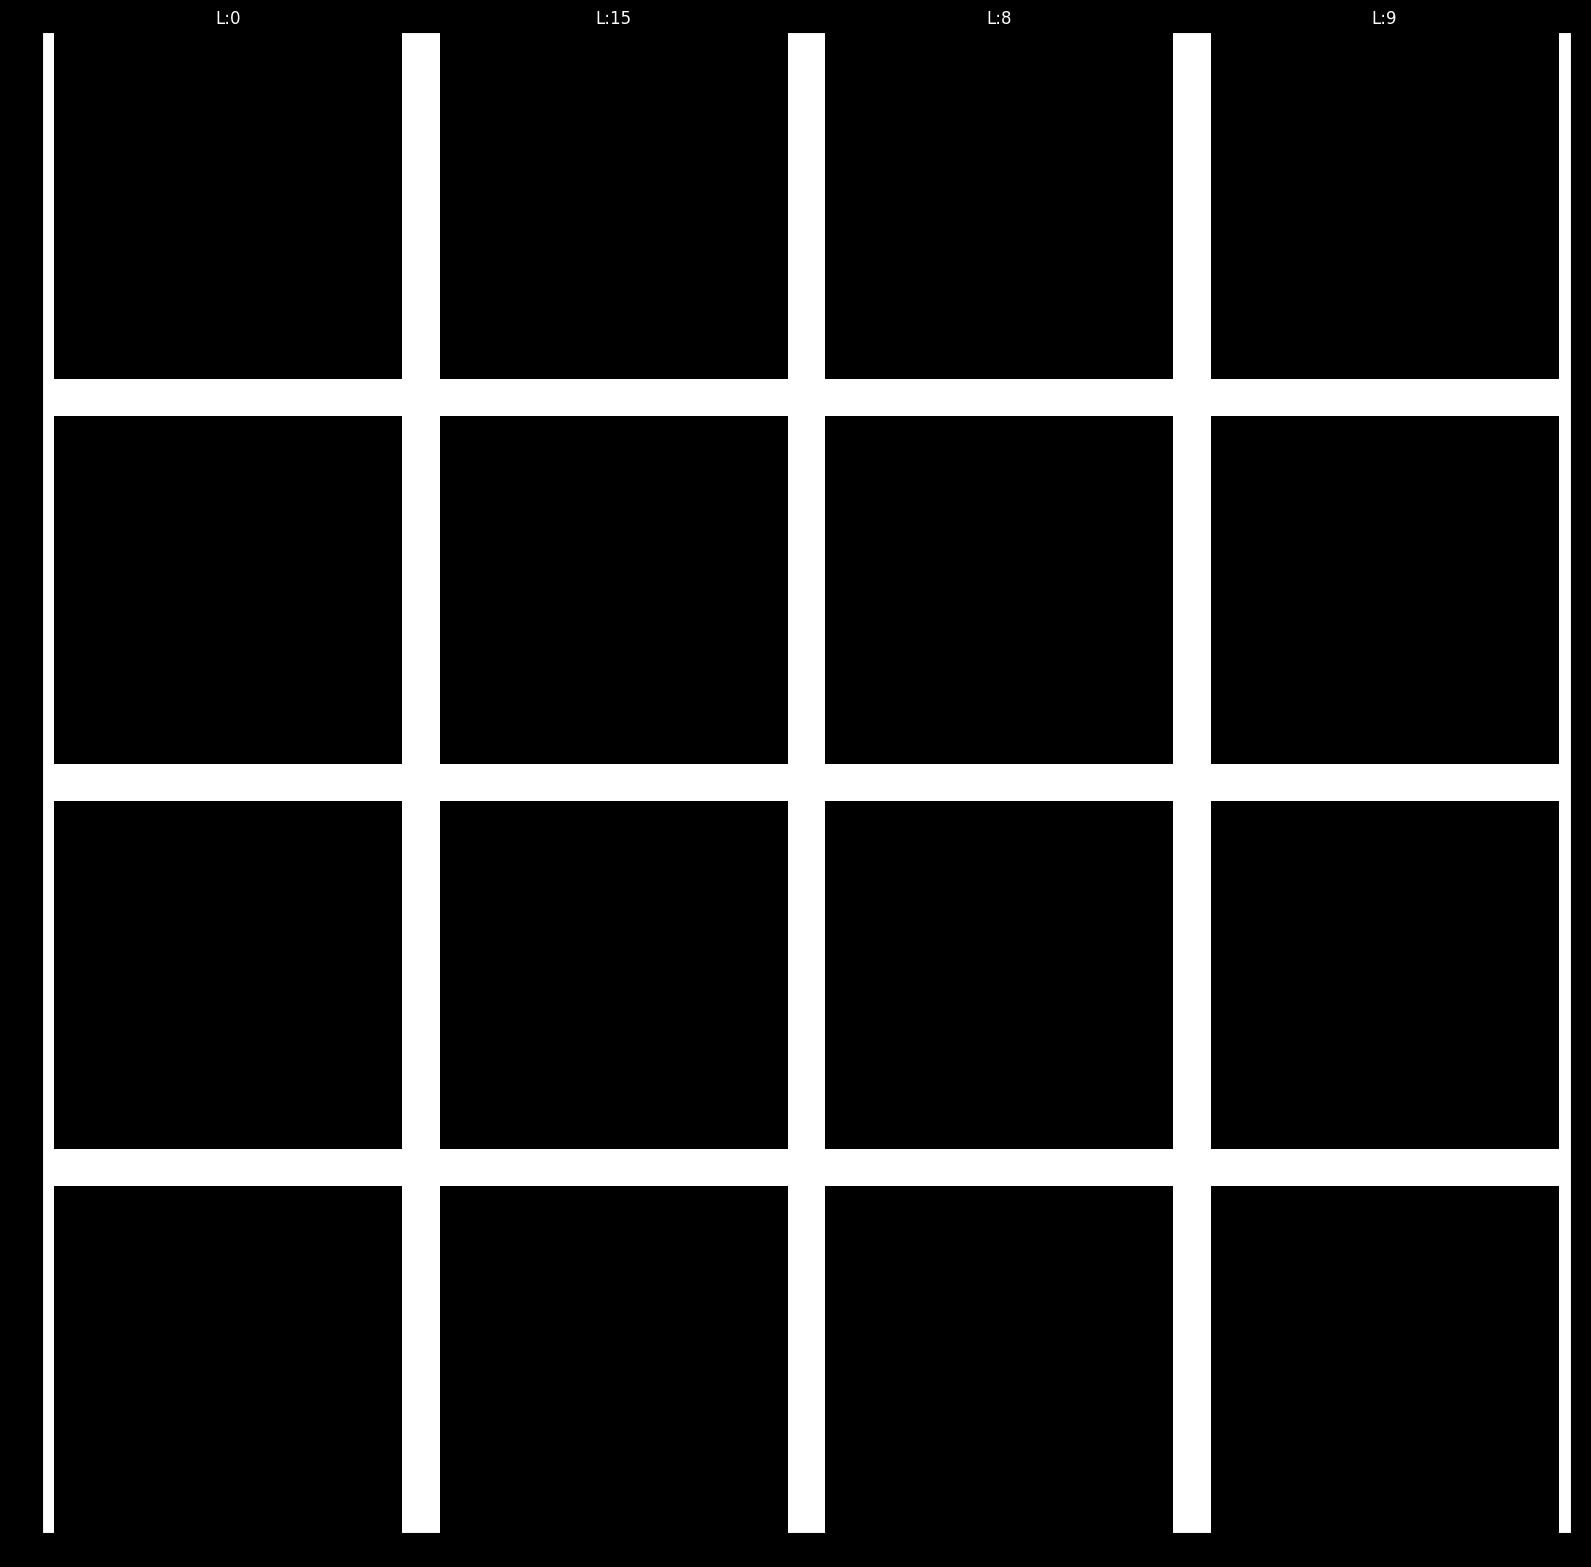

In [ ]:
import math

max_filters = 16
num_filter = features.shape[-1]

if max_filters > num_filter:
    max_filters = num_filter

col_num = int(math.sqrt(max_filters))
row_num = max_filters // col_num
if max_filters % col_num != 0:
    row_num += 1

idxs = random.sample(range(num_filter), max_filters)

fig = plt.figure(figsize=(16, 16), facecolor='black')
plt.title(f"{target_model.layers[target_layer_num].name}")

for i, idx in enumerate(idxs):
    plt.subplot(row_num, col_num, i+1)
    plt.imshow(features[0, :, :, idx], cmap='gray')
    plt.gca().set_title(f"L:{idx}", color='white')
    plt.axis('off')

plt.tight_layout()
plt.show()
